# From Narrative to Precedent: Turkish Court Decision Retrieval and Re-ranking

**Yekta Deniz Durmus** -
**Masters of Software Engineering** -
**University of Europe for Applied Sciences**
 


The system takes a user-provided case narrative (in everyday language or legal language) as input and converts it into a query representation, then performs fast candidate generation over a corpus of court decisions in the first stage (dense retrieval). The output of this stage is a top‑P pool of candidate paragraphs/decisions selected with high recall in mind; this aims to ensure that relevant candidates enter the pool via semantic similarity even when the user’s narrative contains missing or incorrect legal terminology.

In the second stage, the system re-orders this candidate pool more precisely using cross-encoder–based re-ranking, aggregates paragraph-level scores to the case/decision level (pooling), and ultimately returns the top‑K most relevant court decisions to the user. Finally, rather than only presenting a list of decisions, the system additionally searches within each decision text in the top‑K set for “evidence” spans (matched passages/phrases) that align with the user’s narrative, and highlights these spans in the output to make it clearer why each decision was retrieved.

# Research questions


The research questions have been **analyzed separately** in the Kaggle notebook shared below.

To rerun the related code, please open the file **rqs-corresponding-experiments.ipynb** or **run the notebook interactively online** at [link here](https://www.kaggle.com/code/ydenizdurmus/rqs-corresponding-experiments/edit).

The notebook is **also available below as an HTML-rendered view**.



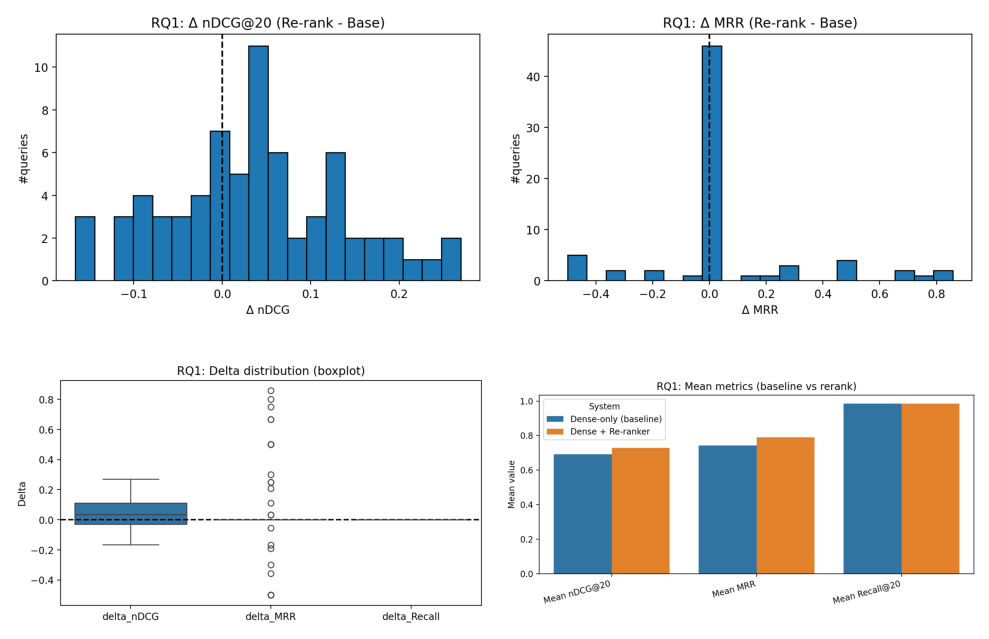
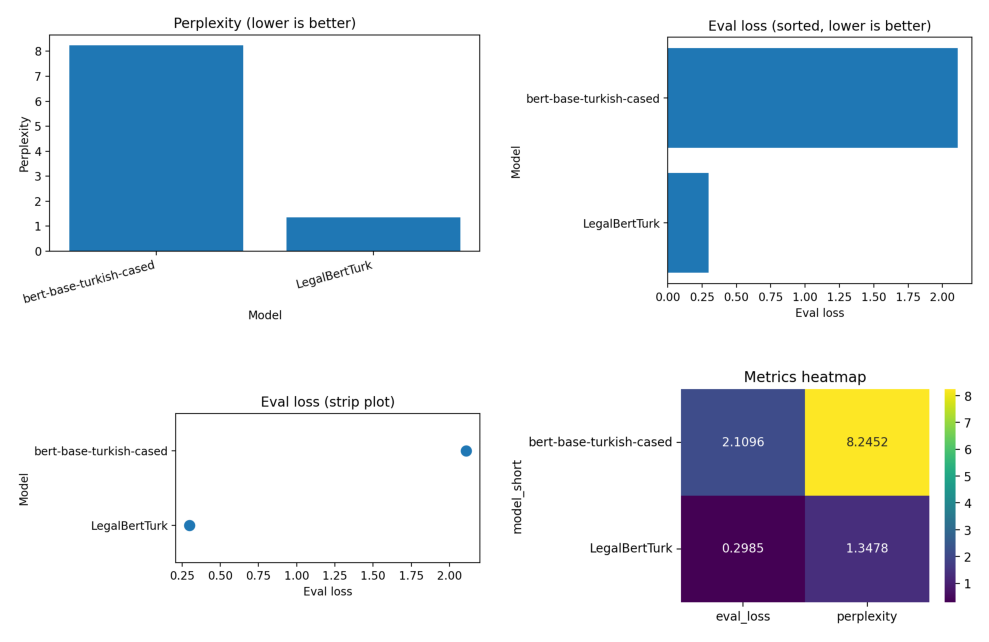
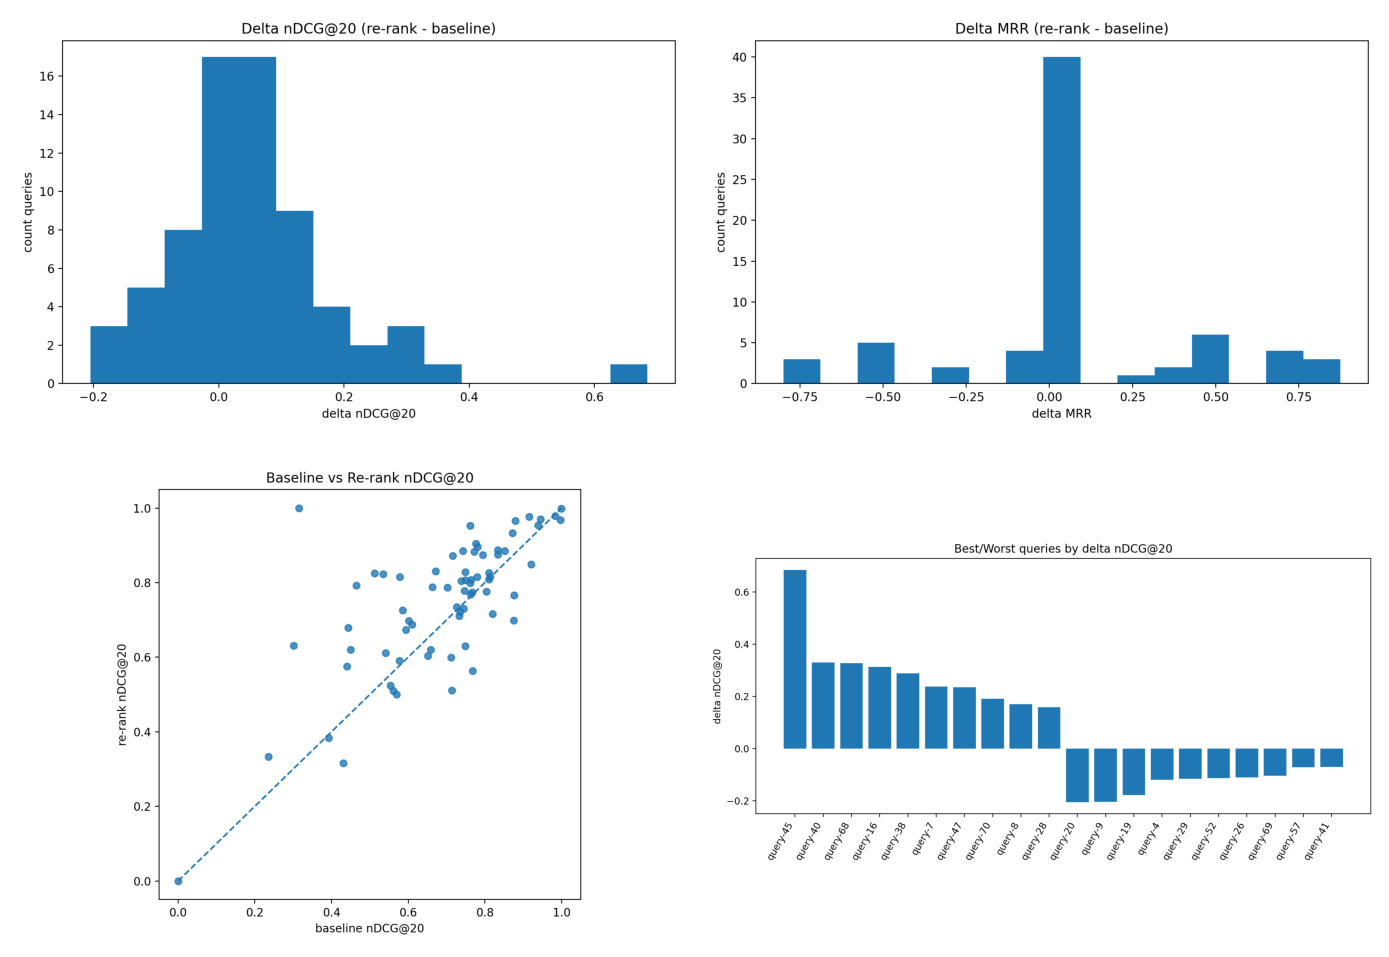
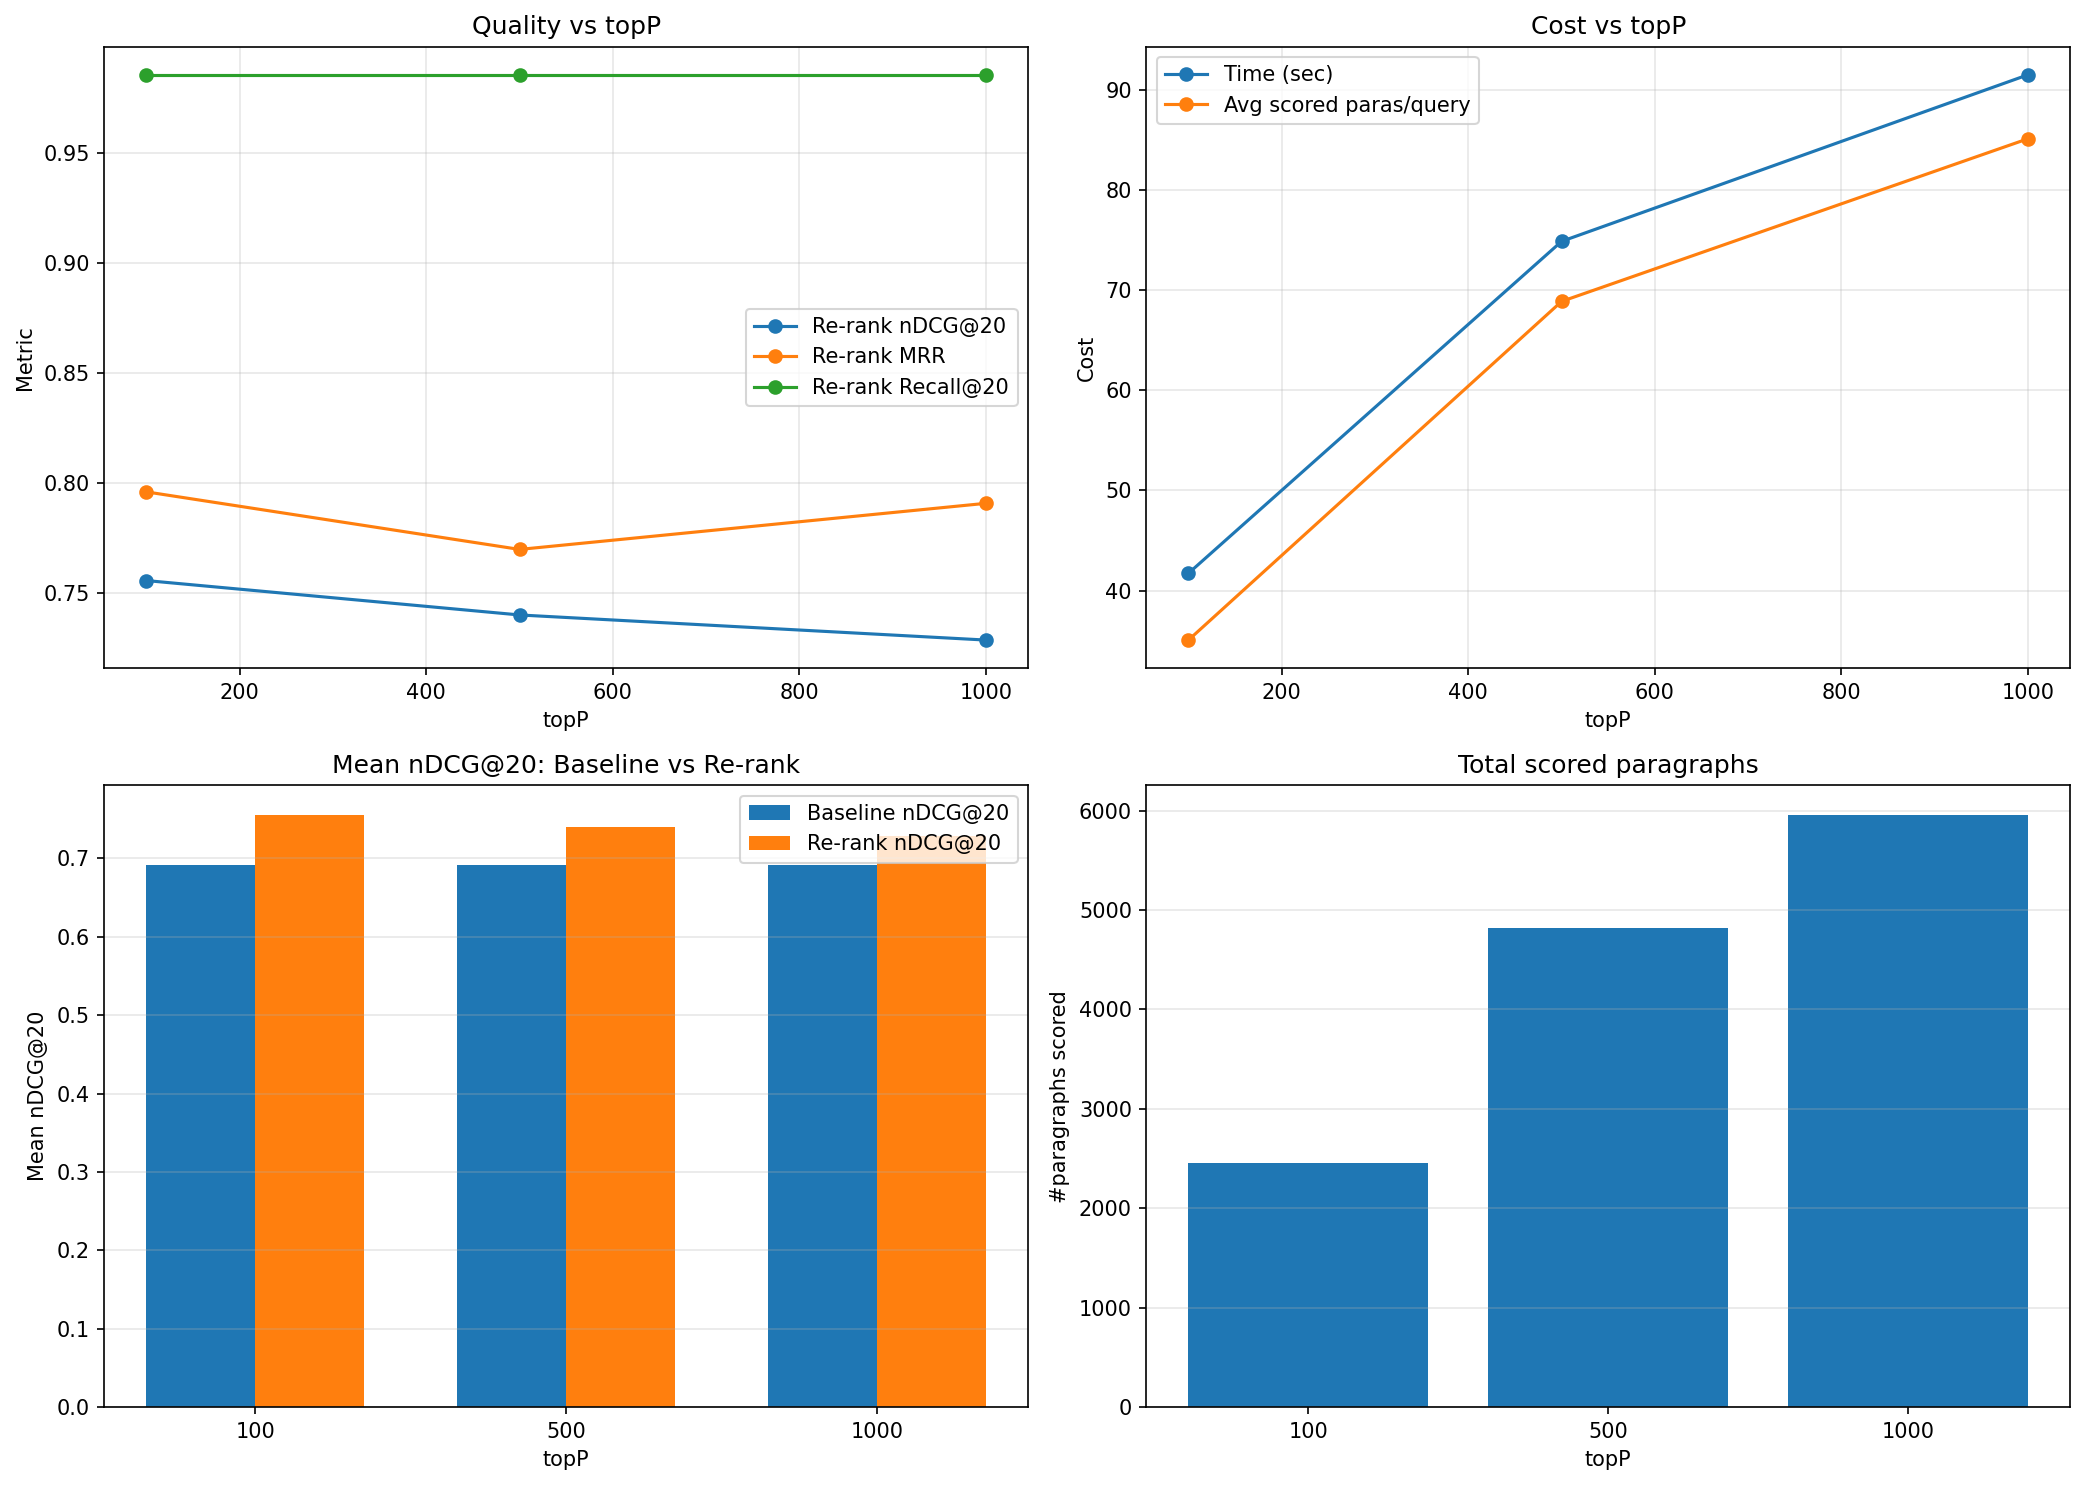
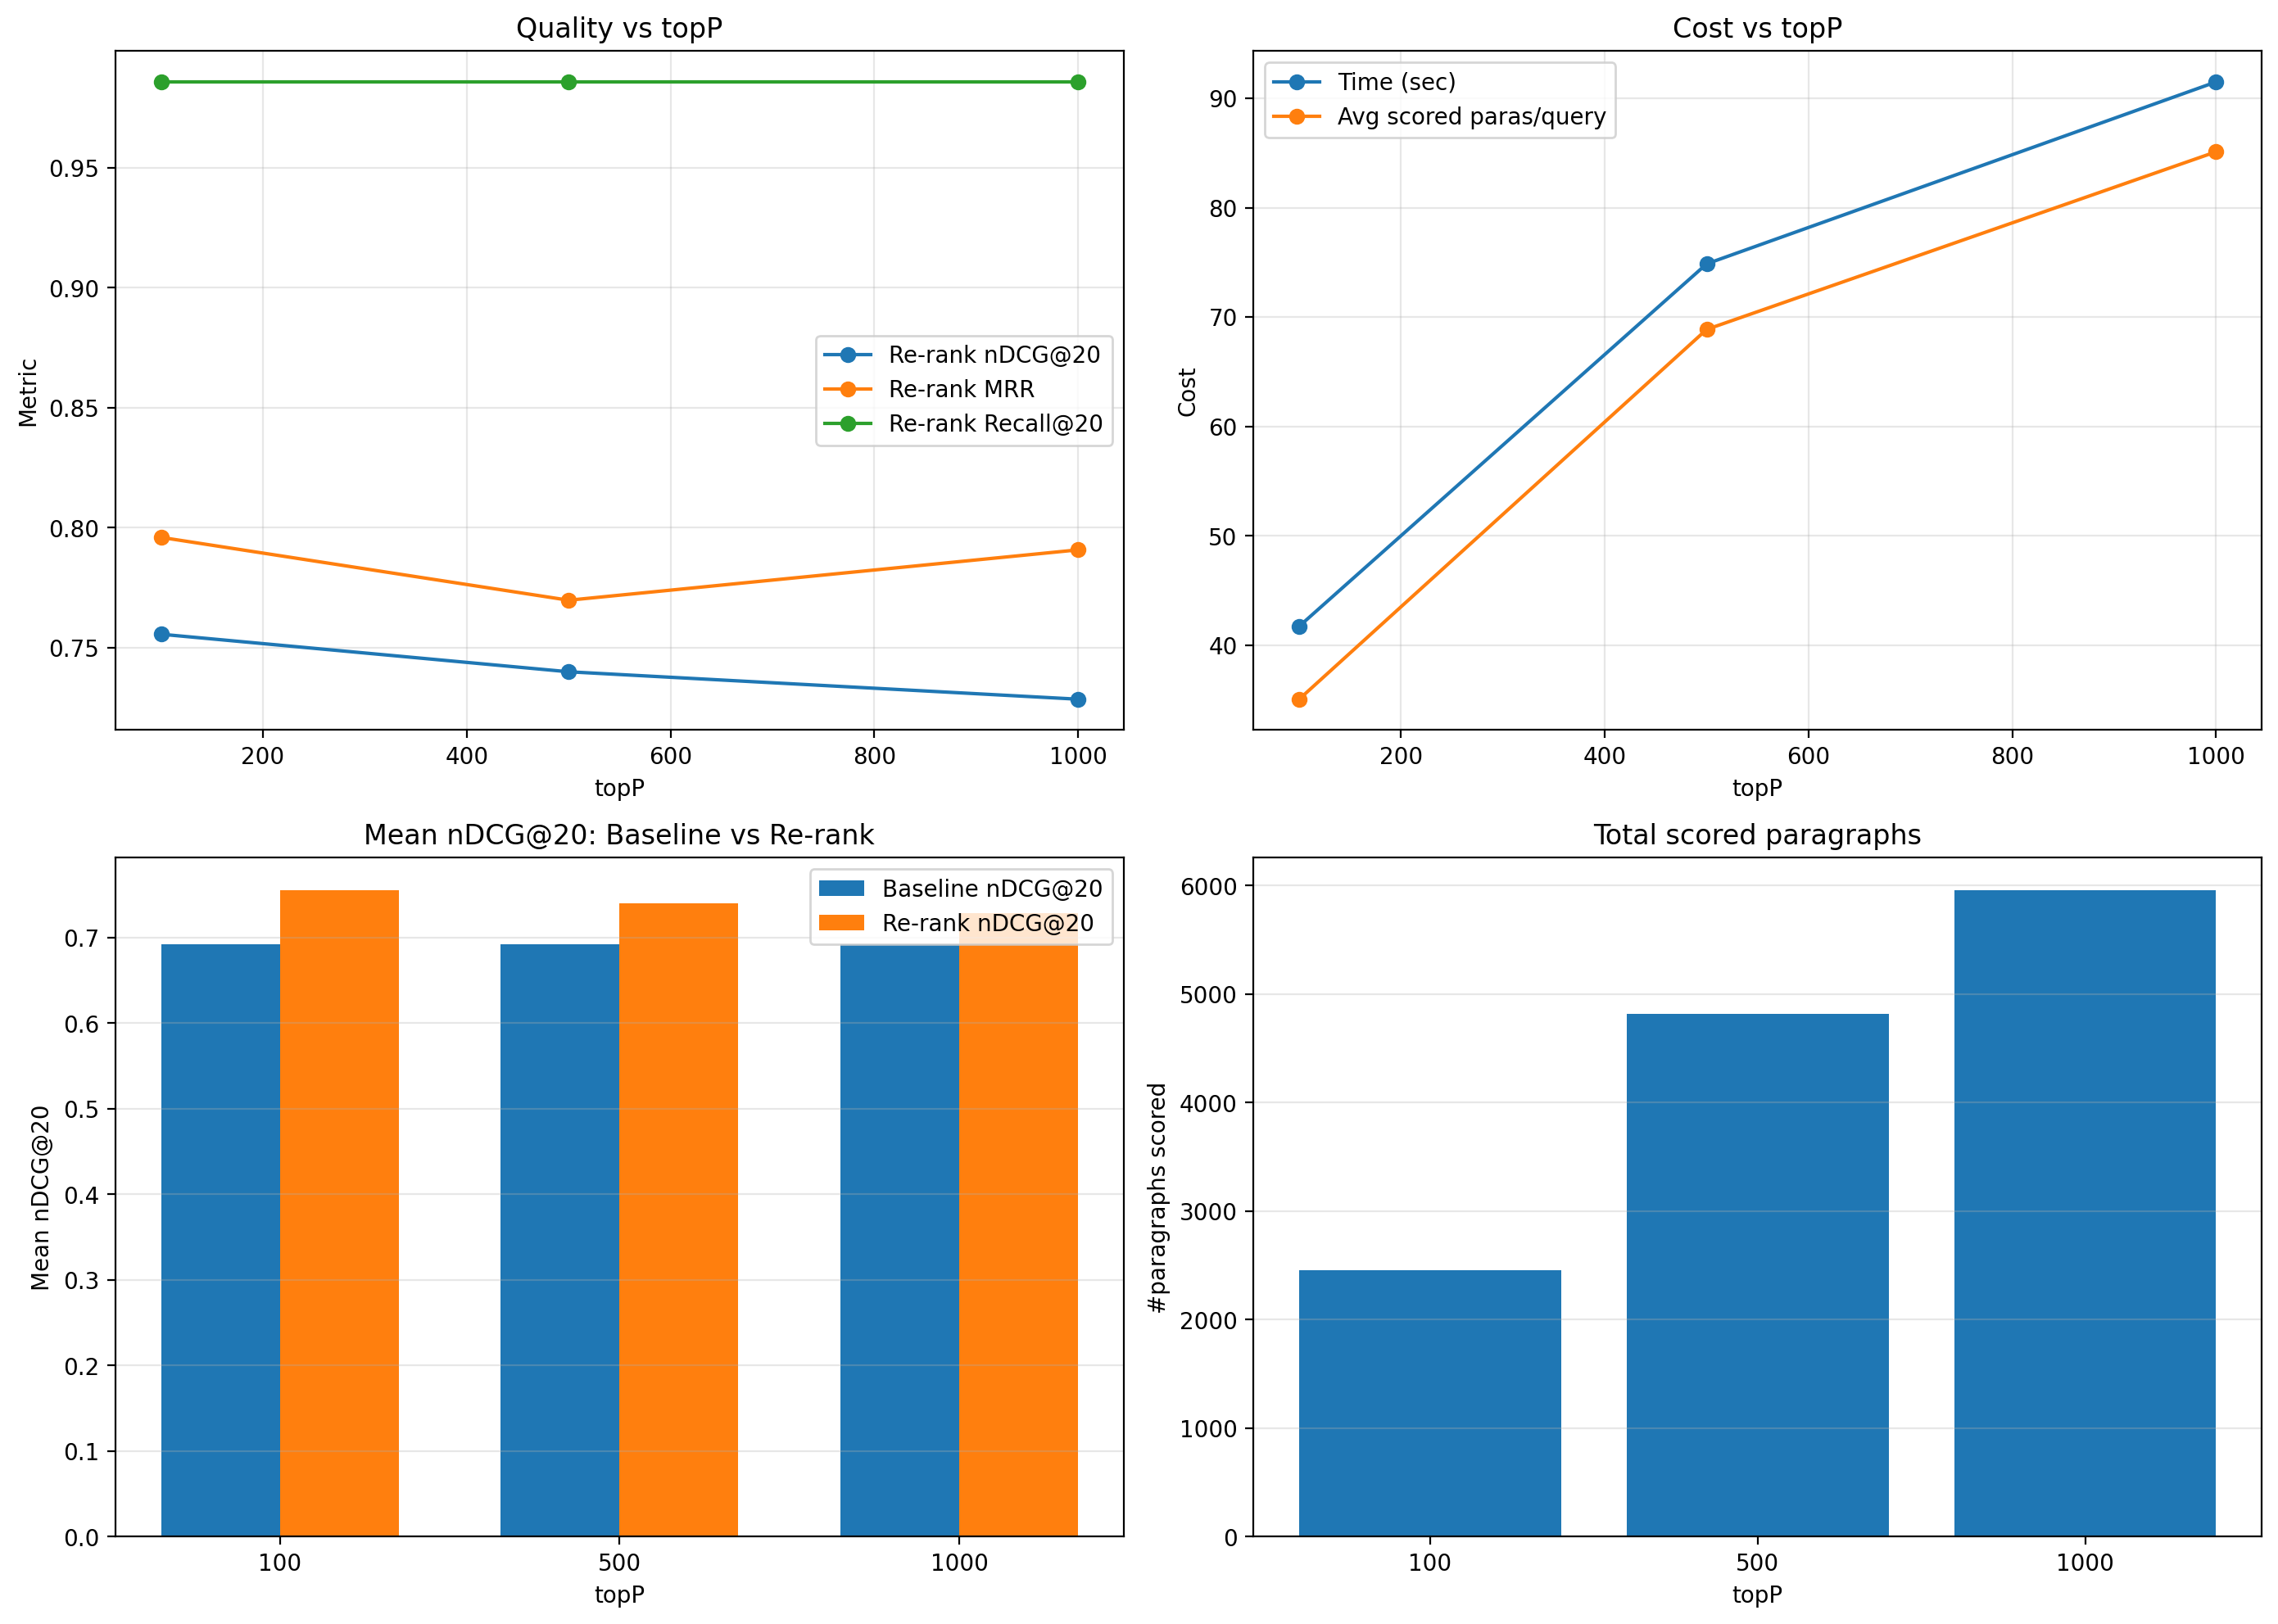
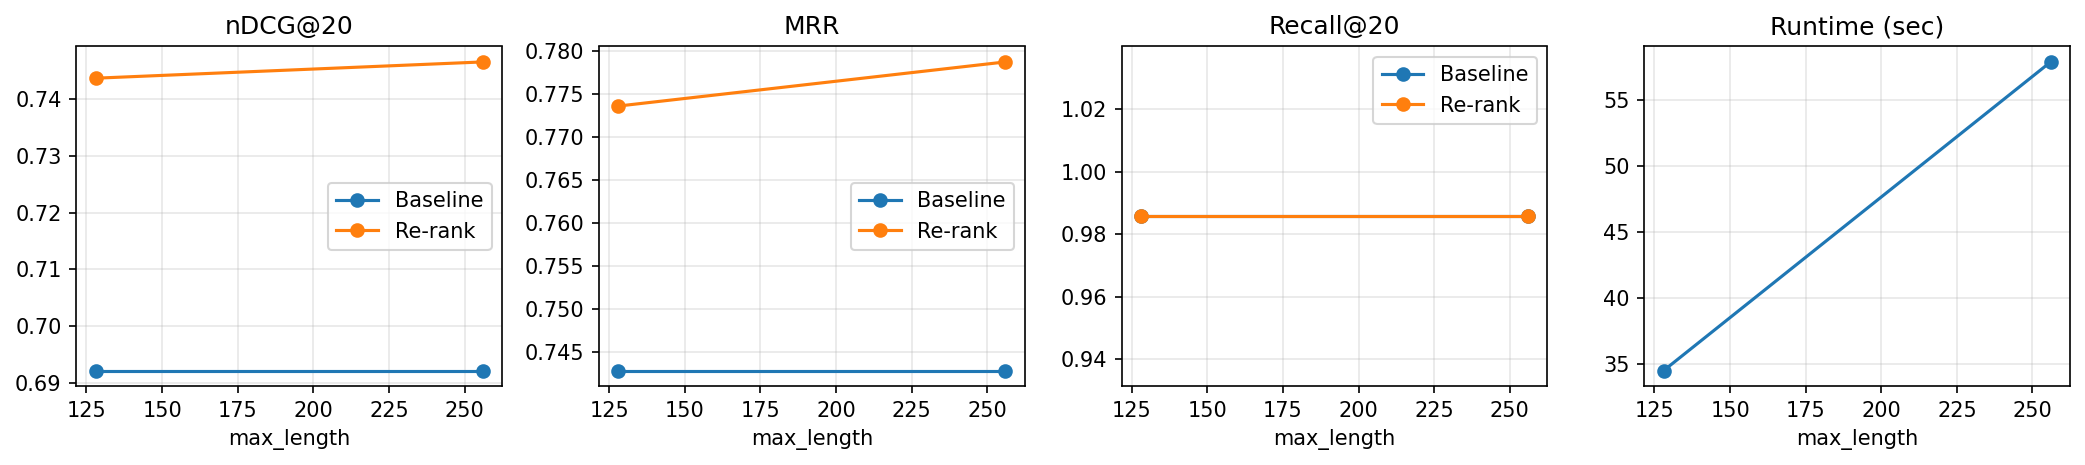

In [1]:
with open('/kaggle/input/html-rqs/rqs-corresponding-experiments.html', 'r', encoding='utf-8') as f:
    html_content = f.read()

from IPython.display import display, HTML
display(HTML(html_content))


# Scope of this notebook

This notebook does not rerun training; MLM and re-ranker training were carried out in separate notebooks and are provided in the appendix.

This notebook loads the ready artefacts under /kaggle/input (embedding model checkpoint, re-ranker checkpoint, FAISS index, and metadata) to run an end-to-end retrieval + re-ranking +exact-match highlighter inference pipeline, and it displays candidate cases for a given query along with their scores/ranking.

Quantitative evaluation (nDCG@20, MRR, Recall@20) and the related tables are computed in a separate evaluation notebook and reported in the appendix.

# Appendix: Training & Evaluation Notebooks

| Item (Notebook / Artefact)                               | Type             | Produced in (where)                              | Used in (where)                                                     | Where it lives at inference                                        |
| -------------------------------------------------------- | ---------------- | ------------------------------------------------ | ------------------------------------------------------------------- | ------------------------------------------------------------------ |
| MLM_Main.ipynb                                           | Notebook         | Runs MLM/domain-adaptation pretraining           | Produces/exports the embedding model checkpoint                     | /kaggle/input/main-mlm-colab-t4-a100                                                              |
| weak-supuvised-labeling.ipynb                            | Notebook         | Generates weak labels for training               | Feeds re-ranker training data prep                                  | /kaggle/input/weak-supuvised-labeling                                                              |
| manuel-ground-truth-gold-relevance-judging.ipynb         | Notebook         | Creates gold relevance judgments                 | Used by evaluation notebook                                         | /kaggle/input/manuel-ground-truth-gold-relevance-judging                                                              |
| Re-ranker-training-A100.ipynb                            | Notebook         | Trains re-ranker (A100)                          | Produces re-ranker checkpoint                                       | /kaggle/input/re-ranker-training-a100                                                              |
| Re-ranker-training-T4.ipynb                              | Notebook         | Trains re-ranker (T4)                            | Produces re-ranker checkpoint                                       | /kaggle/input/re-ranker-training                                                               |
| legalbert-re-ranker-scores-metrics.ipynb                 | Notebook         | Computes metrics                                 | Produces nDCG@20 / MRR / Recall@20 tables                           | /kaggle/input/legalbert-re-ranker-scores-metrics                                                              |
| kaggle/input/legalbertturkpytorchdefault1/LegalBertTurk/ | Model checkpoint | MLM_Main.ipynb (exported checkpoint)             | This notebook loads it for query embedding                          | /kaggle/input/... (as dataset artefact) legalbertturk-final.ipynb​ |
| kaggle/input/re-ranker-model/Re-ranker-last/             | Model checkpoint | Re-ranker-training-*.ipynb (exported checkpoint) | This notebook loads it for paragraph re-ranking                     | /kaggle/input/... (as dataset artefact) legalbertturk-final.ipynb​ |
| kaggle/input/adm-bAdim B/faiss.index                     | Index            | Offline indexing pipeline (separate step)        | This notebook loads it for FAISS retrieval                          | /kaggle/input/... legalbertturk-final.ipynb​                       |
| kaggle/input/adm-bAdim B/faissmeta.jsonl                 | Metadata         | Offline indexing pipeline (separate step)        | This notebook loads it to map faissid → (caseid, paragraphid, text) | /kaggle/input/... legalbertturk-final.ipynb​                       |
| kaggle/input/adm-bAdim B/paragraphs 2.jsonl              | Corpus dump      | Data preparation (separate step)                 | Indirect (source for FAISS+metadata build)                          | /kaggle/input/... legalbertturk-final.ipynb​                       |

# Pipeline

# Cell 0 — Experiment configuration 
In this cell, we define constants to manage the experiment parameters from a single place.  
The goal is to be able to compare different settings by re-running the same notebook while changing only these parameters.  
Collecting parameters in one place also prevents hard-coded values from being scattered across cells and reduces the risk of errors.

In this study:

During the retrieval stage, we will fetch topP = 500 paragraph candidates from FAISS.

For the re-ranker, query–paragraph pairs will be tokenized with max_length = 512 and scored with batch_size = 16.

After producing and ranking case-level scores, we will display the topK = 50 cases.

In the UI output, we will show the full text of the selected evidence paragraph for each case and optionally highlight keywords in yellow when they match exactly.


In [2]:
# === Global config ===
TOPP = 500          # FAISS'ten çekilecek paragraf sayısı
TOPK = 50           # Gösterilecek case sayısı
MAXLEN = 512        # Re-ranker max_length
BATCHSIZE = 16      # Re-ranker batch size

# Evidence gösterimi
EVIDENCE_MODE = "bestpara_fulltext"  # her case için bestparaid paragrafının tam metni


# Cell 1 — Files and setup 
This cell is used to configure paths for data/model files in the Kaggle input directory and to install the required packages.  
Since the same notebook can be opened with different dataset or model versions in the Kaggle environment, explicitly defining paths is important.  
In addition, packages such as FAISS may not be preinstalled in every image, so we use a controlled installation flow here.

Note: Your existing notebook already follows a similar “file check” approach; here we are simply simplifying and parameterizing it.


In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# (Gerekirse) pip
!pip -q install faiss-cpu

# === PATHS (Kaggle input) ===
PATH_FAISSINDEX = "/kaggle/input/adm-b/Adim B/faiss.index"
PATH_FAISSMETA  = "/kaggle/input/adm-b/Adim B/faiss_meta.jsonl"

PATH_LEGALBERTDIR  = "/kaggle/input/legalbertturk/pytorch/default/1/LegalBertTurk"
PATH_RERANKERDIR   = "/kaggle/input/re-ranker-model/Re-ranker-last"

# hızlı kontrol
for p in [PATH_FAISSINDEX, PATH_FAISSMETA, PATH_LEGALBERTDIR, PATH_RERANKERDIR]:
    print(p, "->", "OK" if os.path.exists(p) else "MISSING")


/kaggle/input/html-rqs/rqs-corresponding-experiments.html
/kaggle/input/manuel-ground-truth-gold-relevance-judging/__results__.html
/kaggle/input/manuel-ground-truth-gold-relevance-judging/__notebook__.ipynb
/kaggle/input/manuel-ground-truth-gold-relevance-judging/__output__.json
/kaggle/input/manuel-ground-truth-gold-relevance-judging/custom.css
/kaggle/input/re-ranker-training/__results__.html
/kaggle/input/re-ranker-training/__notebook__.ipynb
/kaggle/input/re-ranker-training/__output__.json
/kaggle/input/re-ranker-training/custom.css
/kaggle/input/re-ranker-training/best_reranker_loss/config.json
/kaggle/input/re-ranker-training/best_reranker_loss/tokenizer.json
/kaggle/input/re-ranker-training/best_reranker_loss/tokenizer_config.json
/kaggle/input/re-ranker-training/best_reranker_loss/model.safetensors
/kaggle/input/re-ranker-training/best_reranker_loss/special_tokens_map.json
/kaggle/input/re-ranker-training/best_reranker_loss/vocab.txt
/kaggle/input/re-ranker-training/best_reran

# Cell 2 — Metadata loading 
FAISS index search returns faiss_id values; the real-world counterparts of these IDs (case_id, paragraph_id, text) are stored in the metadata file.  
In this cell, we load the contents of faiss_meta.jsonl into a DataFrame so that we can map the IDs returned by retrieval to the corresponding paragraph texts.

In the current notebook, there is already an example where the metadata is loaded with the columns: faiss_id, case_id, court, paragraph_id, and text.


In [4]:
import json

def load_jsonl(path: str):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                rows.append(json.loads(line))
    return rows

meta_rows = load_jsonl(PATH_FAISSMETA)
metadf = pd.DataFrame(meta_rows)

metadf = metadf.rename(columns={
    "faiss_id": "faissid",
    "case_id": "caseid",
    "paragraph_id": "paragraphid",
})

print("metadf shape:", metadf.shape)
print("metadf columns:", metadf.columns.tolist())
metadf.head(4)


metadf shape: (243838, 5)
metadf columns: ['faissid', 'caseid', 'court', 'paragraphid', 'text']


,faissid,caseid,court,paragraphid,text
0,0,mahkeme_dataset/danistay.m/dm_3328.txt,danistay.m,0,İSTEMİN KONUSU : ... Vergi Mahkemesinin ... ta...
1,1,mahkeme_dataset/danistay.m/dm_3328.txt,danistay.m,1,YARGILAMA SÜRECİ :\nDava konusu istem: Davacı ...
2,2,mahkeme_dataset/danistay.m/dm_3328.txt,danistay.m,2,TEMYİZ EDENİN İDDİALARI : ... Geri Dönüşüm Hur...
3,3,mahkeme_dataset/danistay.m/dm_3328.txt,danistay.m,3,DANIŞTAY TETKİK HÂKİMİ ...'IN DÜŞÜNCESİ : Temy...


# Cell 3 — Retrieval embedding + FAISS search 
This cell sets up the functions needed to generate query embeddings and retrieve the most similar topP paragraphs from the FAISS index.  
In the current notebook, you generate embeddings using LegalBertTurk with mean pooling + normalization and then perform FAISS search; we will follow the same approach.

Important: This stage only produces the candidate pool (topP paragraphs); the final case ranking is performed by the re-ranker.



In [5]:
import numpy as np
import torch
import faiss
from transformers import AutoTokenizer, AutoModel


# FAISS index
index = faiss.read_index(PATH_FAISSINDEX)
print("faiss ntotal:", index.ntotal)

# Embedding model (LegalBertTurk)
emb_tokenizer = AutoTokenizer.from_pretrained(PATH_LEGALBERTDIR)
emb_model = AutoModel.from_pretrained(PATH_LEGALBERTDIR)
emb_model.eval()

def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)
    summed = (last_hidden_state * mask).sum(dim=1)
    counts = mask.sum(dim=1).clamp(min=1e-9)
    return summed / counts

@torch.no_grad()
def embed_text(texts, maxlen=256):
    enc = emb_tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=maxlen,
        return_tensors="pt"
    )
    out = emb_model(**enc)
    emb = mean_pool(out.last_hidden_state, enc["attention_mask"])
    emb = torch.nn.functional.normalize(emb, p=2, dim=1)
    return emb.cpu().numpy().astype("float32")

def retrieve_paragraphs_for_query(querytext: str, topP: int):
    qvec = embed_text([querytext], maxlen=256)
    D, I = index.search(qvec, topP)
    faissids = I[0].tolist()
    scores = D[0].tolist()

    tmp = metadf[metadf["faissid"].isin(faissids)].copy()
    # skor ve sıralama koru
    score_map = {fid: s for fid, s in zip(faissids, scores)}
    order_map = {fid: i for i, fid in enumerate(faissids)}
    tmp["retrievalscore"] = tmp["faissid"].map(score_map)
    tmp["order"] = tmp["faissid"].map(order_map)
    tmp = tmp.sort_values("order")
    return tmp[["faissid","caseid","paragraphid","text","retrievalscore"]].reset_index(drop=True)


faiss ntotal: 243838


2026-01-04 19:57:51.663705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767556671.685432     189 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767556671.691989     189 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767556671.709605     189 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767556671.709632     189 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767556671.709635     189 computation_placer.cc:177] computation placer alr

# Cell 4 — Re-ranker scoring function 
This cell feeds query + paragraph pairs to the re-ranker and produces scores.  
In the current notebook, the rerankscores() function runs with truncation=True and maxlen=256; here we will use maxlen=512 while keeping batch_size=16 fixed.

Note: The re-ranker model’s sequence classification head outputs a single logit, which you use as the paragraph score.


In [6]:
from transformers import AutoModelForSequenceClassification

rerank_tokenizer = AutoTokenizer.from_pretrained(PATH_RERANKERDIR)
rerank_model = AutoModelForSequenceClassification.from_pretrained(PATH_RERANKERDIR)
rerank_model.eval()

device = "cuda" if torch.cuda.is_available() else "cpu"
rerank_model.to(device)
print("device:", device)

@torch.no_grad()
def rerank_scores(querytext: str, paragraph_texts: list[str], maxlen: int, batchsize: int):
    scores = []
    for i in range(0, len(paragraph_texts), batchsize):
        batch_paras = paragraph_texts[i:i+batchsize]
        enc = rerank_tokenizer(
            [querytext]*len(batch_paras),
            batch_paras,
            padding=True,
            truncation=True,
            max_length=maxlen,
            return_tensors="pt"
        )
        enc = {k: v.to(device) for k, v in enc.items()}
        out = rerank_model(**enc)
        batch_scores = out.logits.squeeze(-1).detach().cpu().numpy().tolist()
        scores.extend(batch_scores)
    return np.array(scores, dtype=np.float32)


device: cuda


# Cell 5 — Case pooling + topK=50 
This cell is the “heart” of the pipeline:

We retrieve the topP paragraphs.

We score each paragraph with the re-ranker and write the results into the candidate table.

We aggregate paragraph scores within the same case_id into a single case score (the current notebook uses log-sum-exp pooling).

For each case, we select the best paragraph as best_para_id; its full text will be shown in the UI.


In [7]:
def casepool_logsumexp(scores: list[float]) -> float:
    scores = np.array(scores, dtype=np.float32)
    if len(scores) == 0:
        return float("-inf")
    m = scores.max()
    return float(m + np.log(np.exp(scores - m).sum()))

def rerank_one_query(querytext: str, topP: int, maxlen: int, batchsize: int):
    # 1) retrieval
    cand = retrieve_paragraphs_for_query(querytext, topP=topP)

    # 2) rerank paragraph-level
    parascores = rerank_scores(querytext, cand["text"].tolist(), maxlen=maxlen, batchsize=batchsize)
    cand = cand.copy()
    cand["rerankscorepara"] = parascores

    # 3) case-level pool + bestparaid
    caserows = []
    for caseid, g in cand.groupby("caseid"):
        case_score = casepool_logsumexp(g["rerankscorepara"].tolist())
        best_row = g.iloc[int(np.argmax(g["rerankscorepara"].values))]
        caserows.append({
            "caseid": caseid,
            "rerankcasescore": case_score,
            "bestparaid": int(best_row["paragraphid"])
        })

    casedf = pd.DataFrame(caserows).sort_values("rerankcasescore", ascending=False).reset_index(drop=True)
    return casedf, cand


# Cell 6 — Exact-match highlighter 
This cell is purely a presentation layer: if the user provides 0–3 keywords, we highlight exact matches in yellow within the full evidence texts of the topK=50 results. This operation does not affect model scores or ranking.

Important details:

“Exact match” means no substring matching; for example, “ceza” matches only “ceza,” not “cezalar.”

For safety, we HTML-escape the text first (and then apply <mark>).


In [8]:
import re, html

TR_WORDCHARS = r"0-9A-Za-zÇĞİÖŞÜçğıöşü_"

def highlight_exact_words(text: str, keywords: list[str]) -> str:
    safe = html.escape(text or "")
    kws = [k.strip() for k in (keywords or []) if k and k.strip()]
    if not kws:
        return safe

    alternation = "|".join(re.escape(k) for k in kws)
    pattern = rf"(?<![{TR_WORDCHARS}])({alternation})(?![{TR_WORDCHARS}])"

    return re.sub(
        pattern,
        lambda m: f"<mark style='background:#ffeb3b;'>{m.group(1)}</mark>",
        safe,
        flags=re.IGNORECASE
    )


# Cell 7 — Run a single query + show topK=50 
This cell allows the notebook to be run independently of any dataset by taking manual user input. The goal is to test the retrieval + re-ranking pipeline by directly entering a “question/case text” (query), without loading any CSV files.

Optionally, the user can provide 0–3 keywords. These keywords are used only to highlight exact matches in the evidence text shown in the UI; they do not affect the ranking (model scores). If no keywords are provided, no highlighting is applied and the text is displayed normally.

With this design, the notebook is suitable both for quick demos (single query) and for step-by-step debugging.


**Example case query -->**


Ahmet, İstanbul’da bir daireyi 1 yıllığına kiralamak üzere Mehmet ile kira sözleşmesi imzalar. Sözleşmede, kira bedeli aylık 3.000 TL olarak belirlenmiştir ve ödeme her ayın başında yapılacaktır. Sözleşmenin 6. ayında Ahmet, ekonomik sebeplerle kira bedelini ödemekte gecikmeye başlar ve 2 ay boyunca kira ödemelerini yapmaz. Mehmet, Ahmet’e yazılı uyarı gönderir ve kira bedelinin derhal ödenmesini talep eder. Ahmet, uyarıya rağmen kira borcunu ödememeye devam eder. Mehmet, yasal haklarını kullanarak kira sözleşmesini feshetmek ve tahliye talebinde bulunmak için mahkemeye başvurur. Mahkeme, kira sözleşmesinde belirtilen ödeme yükümlülüğünün yerine getirilmemesinin sözleşmenin haklı nedenle feshi için yeterli olduğunu değerlendirir. Ahmet’in iki aylık kira borcunun önemli bir ihlal olduğu sonucuna varılır. Ahmet ise ekonomik zorluklar yaşadığını ve ödeme yapamadığını, ancak evi tahliye etmek istemediğini belirtir. Mahkeme, Ahmet’in durumunu göz önünde bulundurarak bir miktar ek süre verilmesine karar verir. Sonuç olarak, mahkeme kira borcunun ödenmesi için Ahmet’e ek süre tanırken, Mehmet’in tahliye talebi reddedilir. Ancak, Ahmet’in borcunu ödememesi halinde sözleşmenin feshedilmesine karar verileceği belirtilir.

**Example case keywords -->**

kira bedeli, fesih, tahliye

In [9]:
# --- Manuel query ---
querytext = input("Please enter a query: ").strip()
if not querytext:
    raise ValueError("Query can not be empty.")

# --- Opsiyonel keyword'ler (0-3) ---
kw1 = input("Keyword 1 (optional): ").strip()
kw2 = input("Keyword 2 (optional): ").strip()
kw3 = input("Keyword 3 (optional): ").strip()
keywords = [k for k in [kw1, kw2, kw3] if k]

print("Query (ilk 200):", querytext[:200], "..." if len(querytext) > 200 else "")
print("Keywords:", keywords)


Please enter a query:  Ahmet, İstanbul’da bir daireyi 1 yıllığına kiralamak üzere Mehmet ile kira sözleşmesi imzalar. Sözleşmede, kira bedeli aylık 3.000 TL olarak belirlenmiştir ve ödeme her ayın başında yapılacaktır. Sözleşmenin 6. ayında Ahmet, ekonomik sebeplerle kira bedelini ödemekte gecikmeye başlar ve 2 ay boyunca kira ödemelerini yapmaz. Mehmet, Ahmet’e yazılı uyarı gönderir ve kira bedelinin derhal ödenmesini talep eder. Ahmet, uyarıya rağmen kira borcunu ödememeye devam eder. Mehmet, yasal haklarını kullanarak kira sözleşmesini feshetmek ve tahliye talebinde bulunmak için mahkemeye başvurur. Mahkeme, kira sözleşmesinde belirtilen ödeme yükümlülüğünün yerine getirilmemesinin sözleşmenin haklı nedenle feshi için yeterli olduğunu değerlendirir. Ahmet’in iki aylık kira borcunun önemli bir ihlal olduğu sonucuna varılır. Ahmet ise ekonomik zorluklar yaşadığını ve ödeme yapamadığını, ancak evi tahliye etmek istemediğini belirtir. Mahkeme, Ahmet’in durumunu göz önünde bulundurarak b

Query (ilk 200): Ahmet, İstanbul’da bir daireyi 1 yıllığına kiralamak üzere Mehmet ile kira sözleşmesi imzalar. Sözleşmede, kira bedeli aylık 3.000 TL olarak belirlenmiştir ve ödeme her ayın başında yapılacaktır. Sözl ...
Keywords: ['kira bedeli,']


# Cell 8 
This cell sends the query entered in Cell 7 through the pipeline:

It retrieves TOPP = 500 paragraph candidates from FAISS.

It scores each paragraph with the re-ranker (MAXLEN = 512, BATCHSIZE = 16).

It aggregates scores at the case level and selects the best TOPK = 50 cases.

For each case, it displays the full text of the best paragraph (best_para_id) and highlights exact keyword matches if any keywords are provided.


In [10]:
from IPython.display import display, HTML
import html as _html

# 1) pipeline
casedf, cand = rerank_one_query(querytext, topP=TOPP, maxlen=MAXLEN, batchsize=BATCHSIZE)
top = casedf.head(TOPK)

# 2) gösterim: bestparaid tam metin + exact highlight
for rank_idx, row in top.iterrows():
    caseid = row["caseid"]
    bestparaid = int(row["bestparaid"])
    score = float(row["rerankcasescore"])

    ev_rows = cand[(cand["caseid"] == caseid) & (cand["paragraphid"] == bestparaid)]
    if len(ev_rows) == 0:
        fulltext = ""
    else:
        fulltext = str(ev_rows.iloc[0]["text"])

    html_text = highlight_exact_words(fulltext, keywords)

    block = f"""
    <div style="border:1px solid #ddd; padding:10px; margin:10px 0;">
      <div>
        <b>rank</b>: {rank_idx+1}
        | <b>caseid</b>: {_html.escape(str(caseid))}
        | <b>score</b>: {score:.4f}
        | <b>bestparaid</b>: {bestparaid}
      </div>
      <div style="margin-top:8px; max-height:260px; overflow:auto; white-space:pre-wrap;">
        {html_text}
      </div>
    </div>
    """
    display(HTML(block))
